In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps
from npspy import npsc

In [2]:
torch.set_num_threads(10)

all_peps = [
    '1K', '1R', 
    '1D', '1E', 
    '1F', '1W', '1Y', '1I', '1L', '1M', '1V', '1H', '1Q', '1A', '1G', '1S', '1C', '1P', '1T', '1N',
]

all_classes = [
    'clean',
    'rejected',
]
y_code_dict = nps.ml.set_y_codes_for_classes(np.array(all_classes)[:,None])
y_code_dict
y_to_label_dict = {v:k for k,v in y_code_dict.items()}
y_code_dict, y_to_label_dict

({np.str_('clean'): 0, np.str_('rejected'): 1},
 {0: np.str_('clean'), 1: np.str_('rejected')})

In [3]:
rejected_obj = {}
for pep in all_peps:
    one_obj = nps.io.read_pickle(f"../../../03.results/classification_on_clean_data/GSXGS/{pep}/{pep}_valid80_rejected_obj.pkl")
    rejected_obj.update(one_obj)

In [4]:
clean_obj = {}
for pep in all_peps:
    one_obj = nps.io.read_pickle(f"../../../03.results/classification_on_clean_data/GSXGS/{pep}/{pep}_valid80_clean_obj.pkl")
    clean_obj.update(one_obj)

In [5]:
len(clean_obj), len(rejected_obj)

(732437, 310358)

In [8]:
labels = all_classes

def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

In [9]:
train_df = nps.ml.get_X_y_from_objs(objs=[clean_obj, rejected_obj], labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
train_df = stratified_sample(train_df, 'y', sample_size=310000, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=1/8, random_state=42, stratify=train_df['y'])

In [11]:
batch_size = 64
train_dl = nps.ml.construct_dataloader_from_data_df(train_df, batch_size=batch_size, augment=False)
valid_dl = nps.ml.construct_dataloader_from_data_df(valid_df, batch_size=batch_size)

In [12]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
clf.fit(train_dl, valid_dl, early_stopping_patience=30, name='cls_clean_and_rejected')

Model CNN1DL1000 has total parameter number: 6.21 M
Epoch   0 / 200 train_loss: 0.8628 train_acc: 0.8631 val_loss: 0.9310 val_acc: 0.8242 lr: 0.005
Epoch   1 / 200 train_loss: 0.8086 train_acc: 0.8887 val_loss: 0.7952 val_acc: 0.8949 lr: 0.005
Epoch   2 / 200 train_loss: 0.7931 train_acc: 0.8969 val_loss: 0.7943 val_acc: 0.8982 lr: 0.005
Epoch   3 / 200 train_loss: 0.7834 train_acc: 0.9029 val_loss: 0.8171 val_acc: 0.8888 lr: 0.005
Epoch   4 / 200 train_loss: 0.7759 train_acc: 0.9069 val_loss: 0.7834 val_acc: 0.9022 lr: 0.005
Epoch   5 / 200 train_loss: 0.7709 train_acc: 0.9096 val_loss: 0.7895 val_acc: 0.8981 lr: 0.005
Epoch   6 / 200 train_loss: 0.7665 train_acc: 0.9121 val_loss: 0.8037 val_acc: 0.8919 lr: 0.005
Epoch   7 / 200 train_loss: 0.7636 train_acc: 0.9133 val_loss: 0.7871 val_acc: 0.9020 lr: 0.005
Epoch   8 / 200 train_loss: 0.7611 train_acc: 0.9147 val_loss: 0.7689 val_acc: 0.9097 lr: 0.005
Epoch   9 / 200 train_loss: 0.7585 train_acc: 0.9164 val_loss: 0.7587 val_acc: 0.916

# 对valid20的数据进行预测

In [13]:
pep = '1S'
obj = nps.io.read_pickle(f"../../../00.data/GSXGS/{pep}_valid20.pkl")

In [14]:
test_objs = [obj]
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=['clean'], y_code_dict=y_code_dict, down_sample_to=1000, att='signal')

In [15]:
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

In [16]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(all_peps), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
pred_df = clf.predict(test_dl, name='cls_clean_and_rejected', y_to_label_dict=y_to_label_dict)

Model CNN1DL1000 has total parameter number: 6.21 M
 test_acc: 0.6596


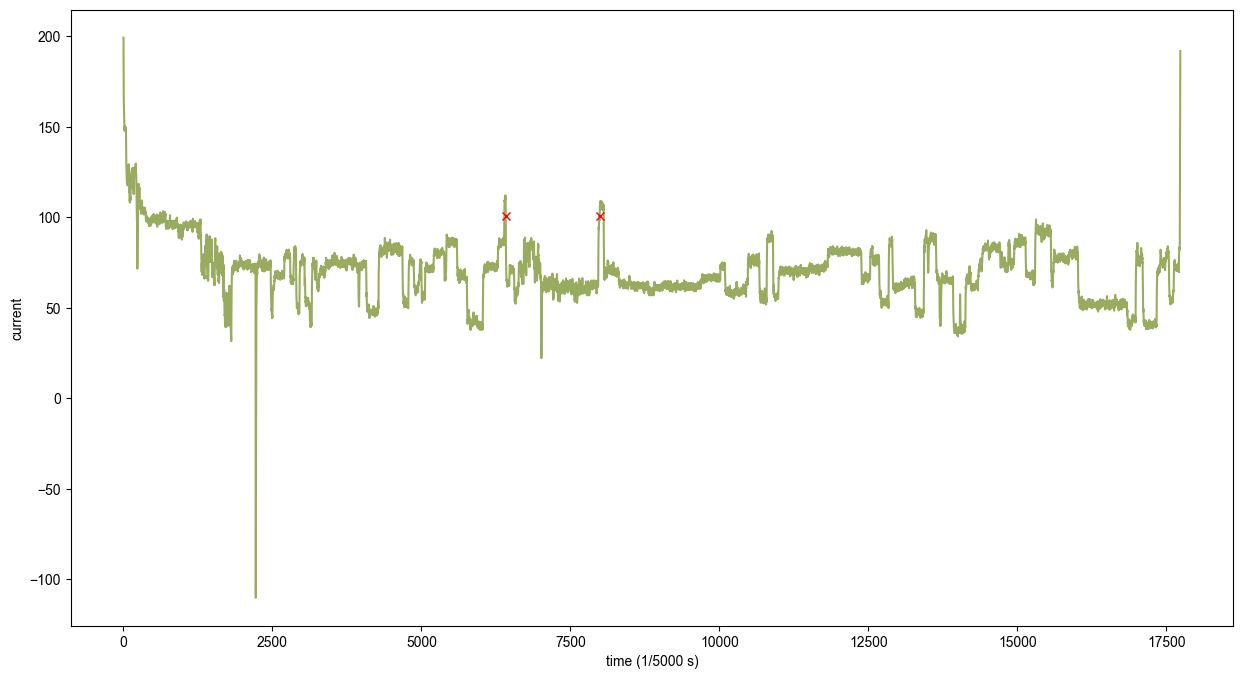

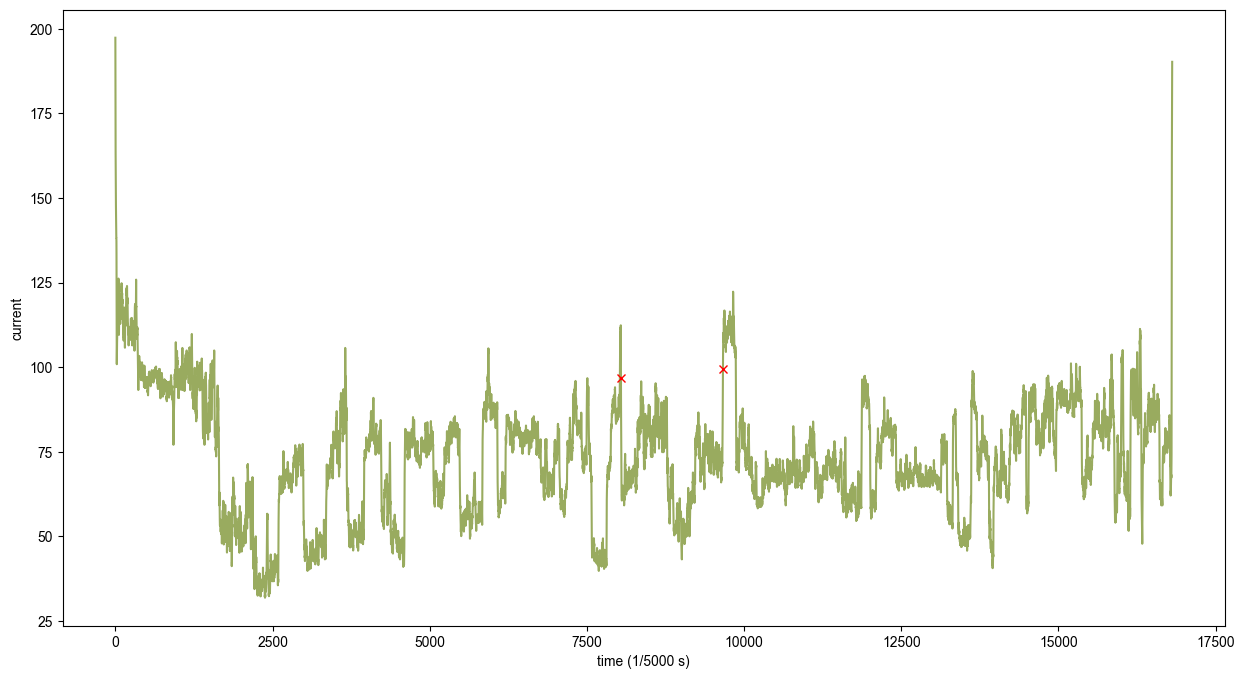

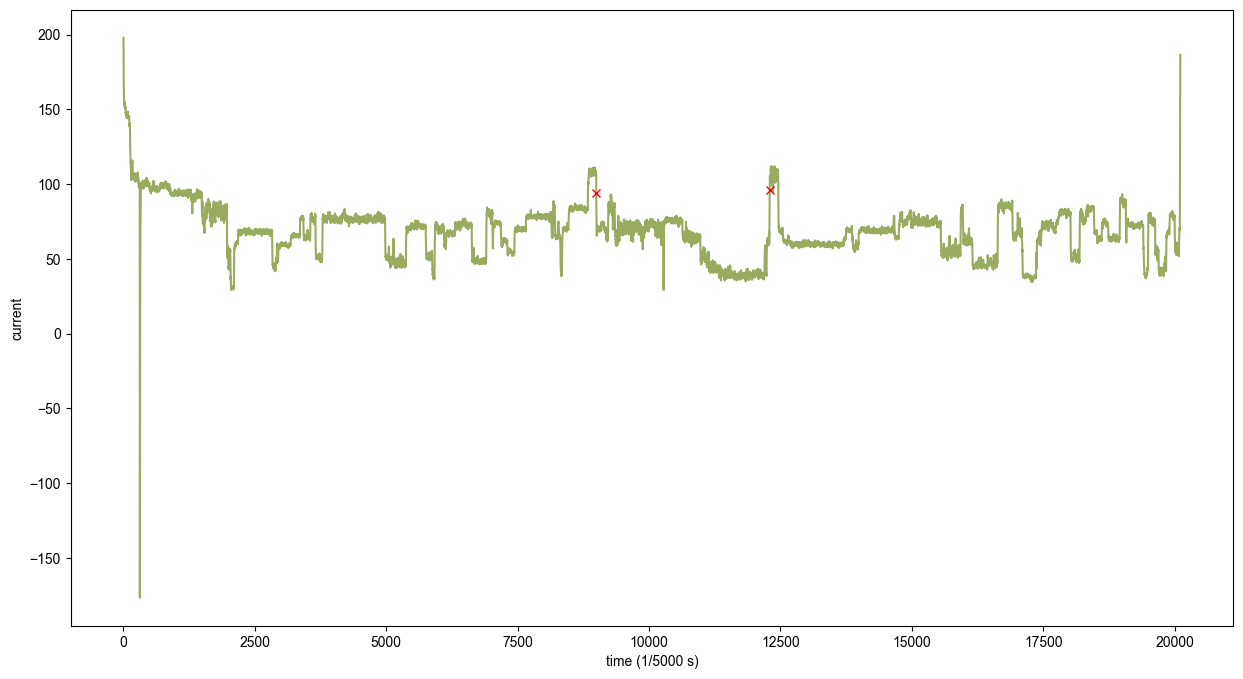

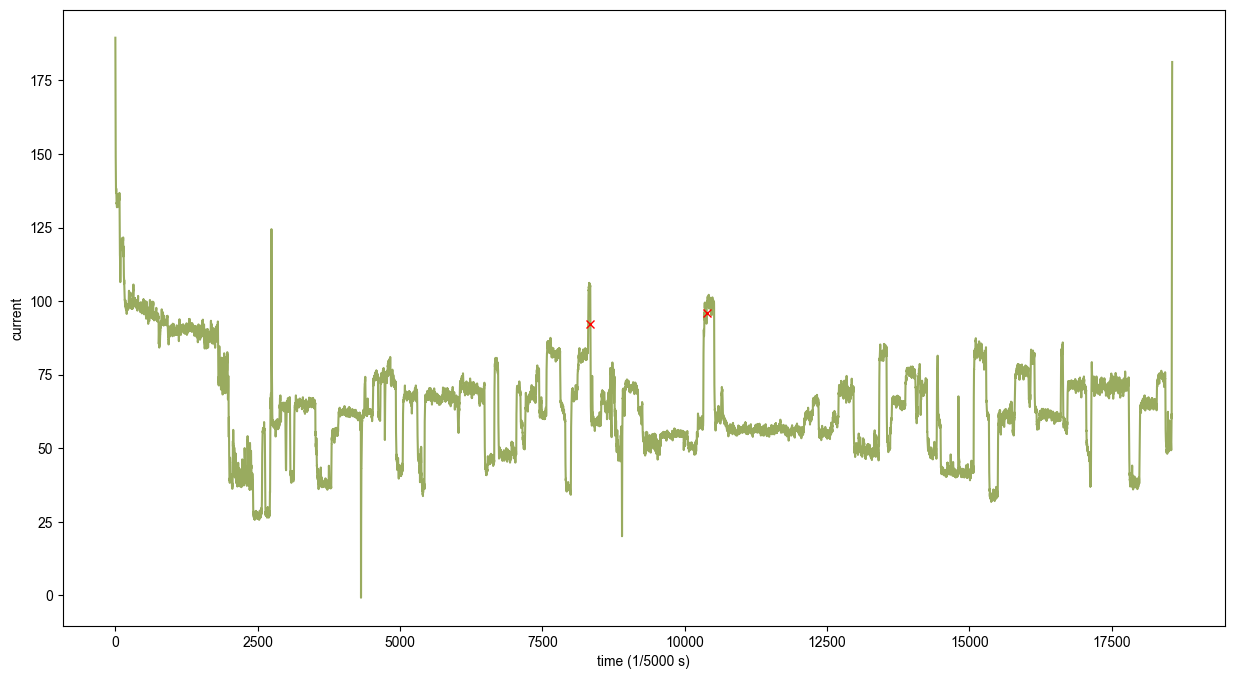

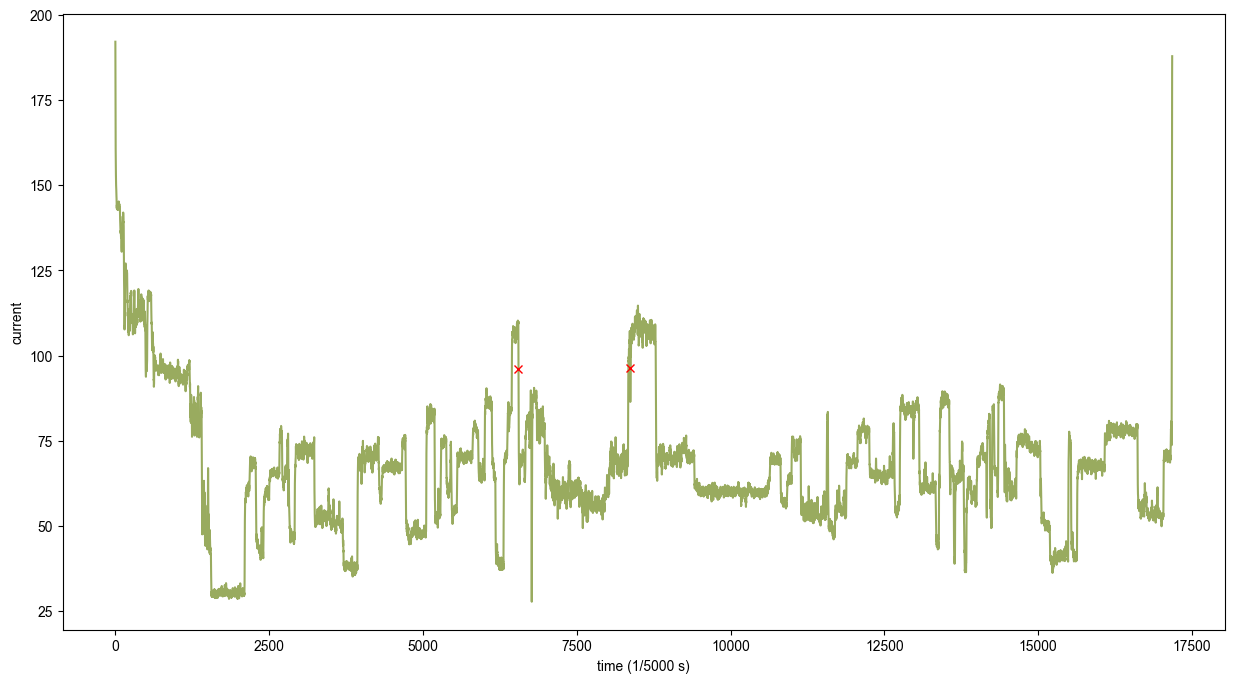

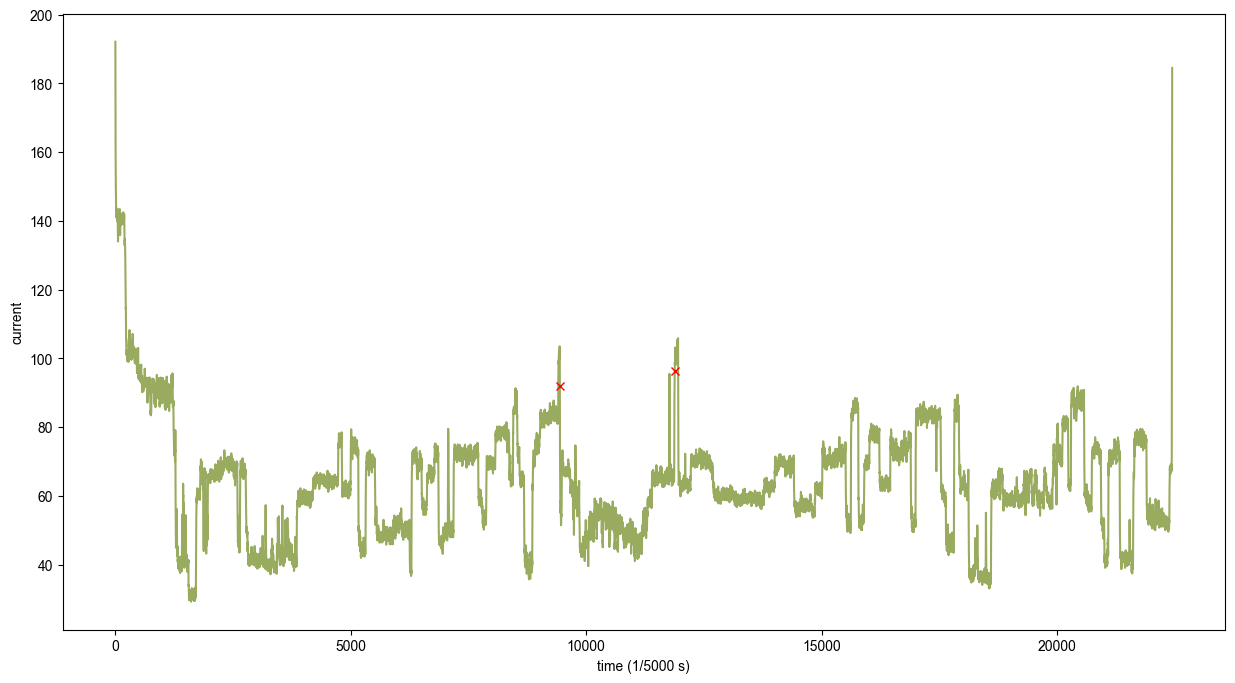

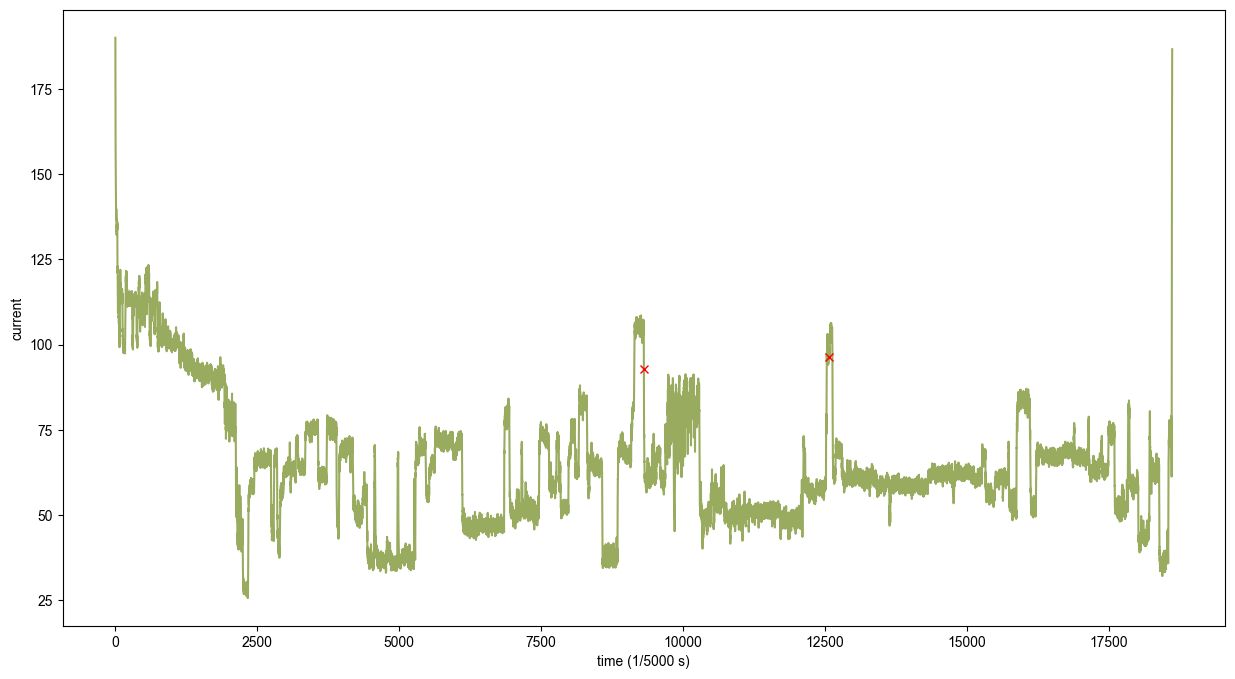

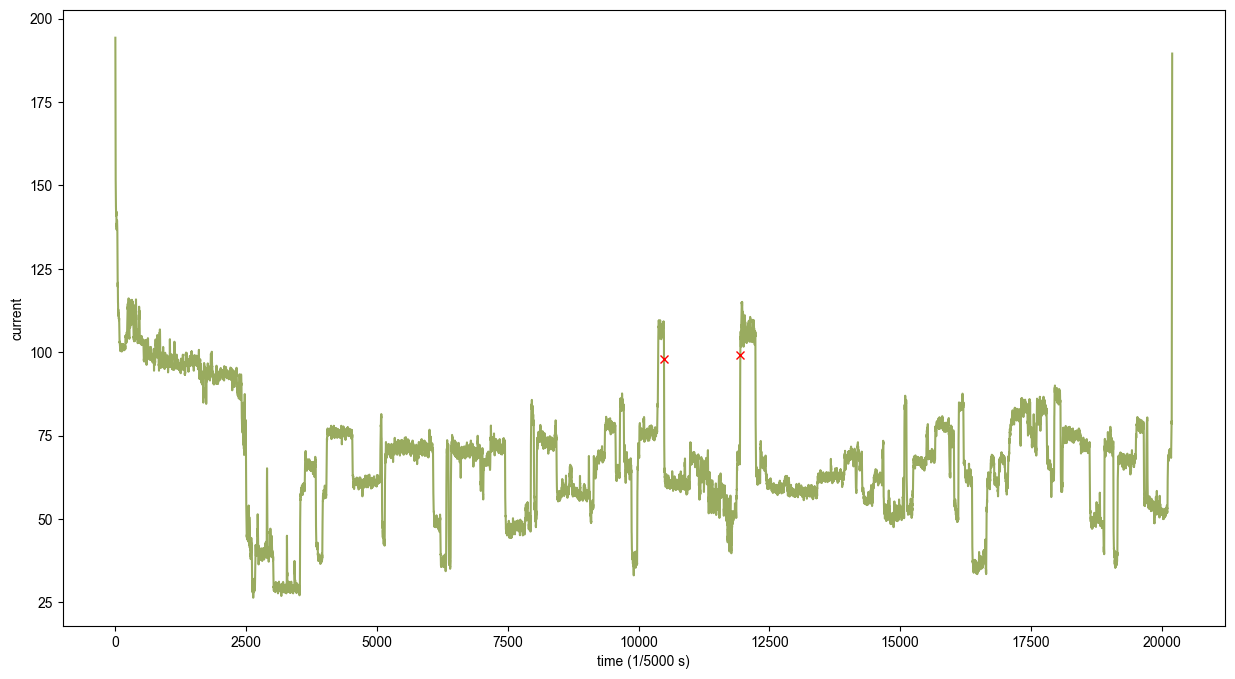

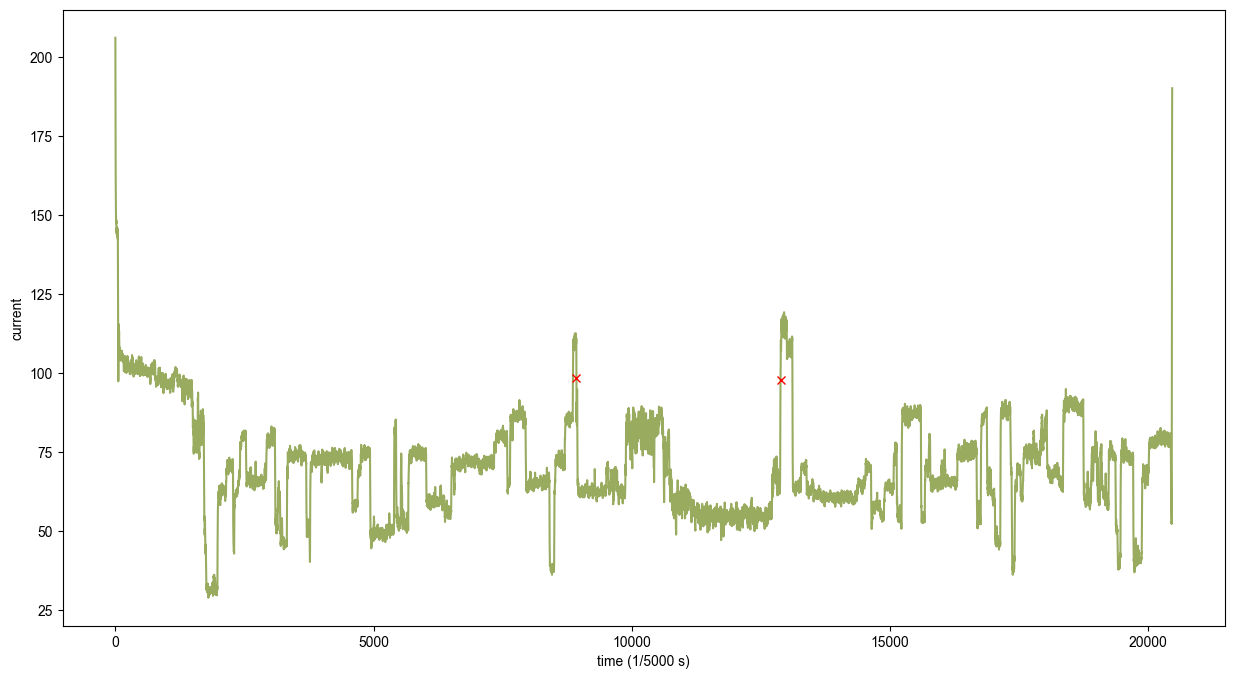

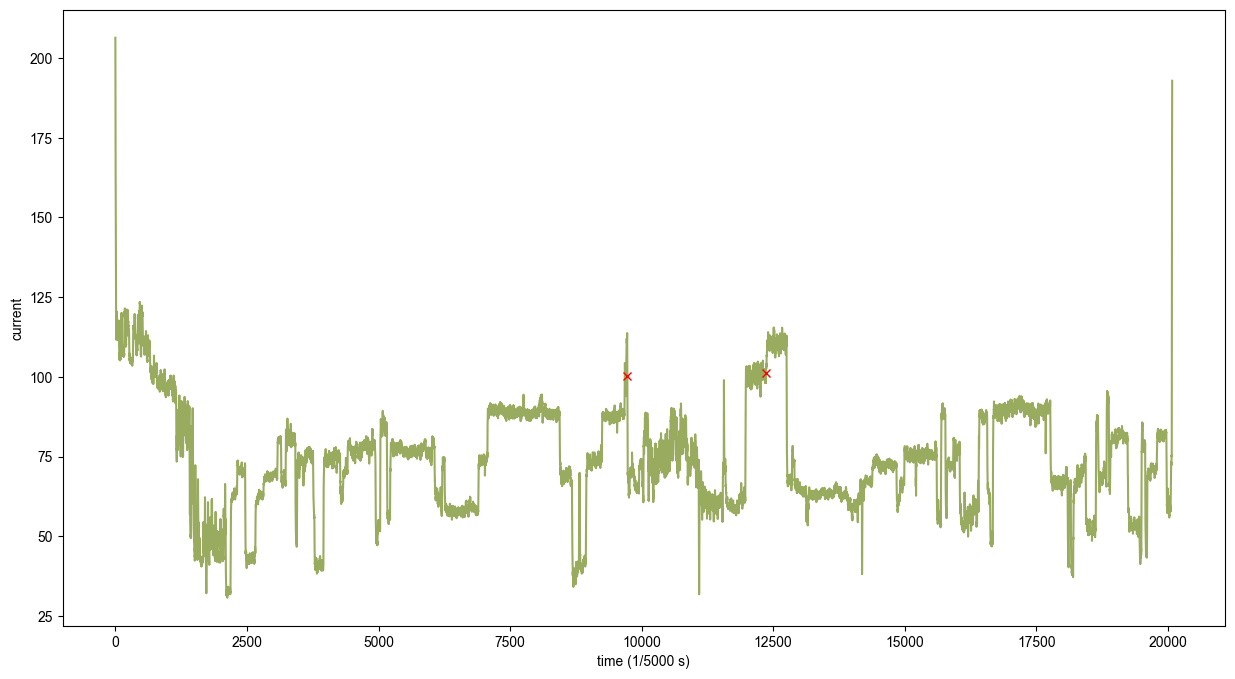

In [17]:
for i in range(10):
    nps.pl.draw_one_read_with_window(obj, pred_df[pred_df['pred']=='clean'].index[i])

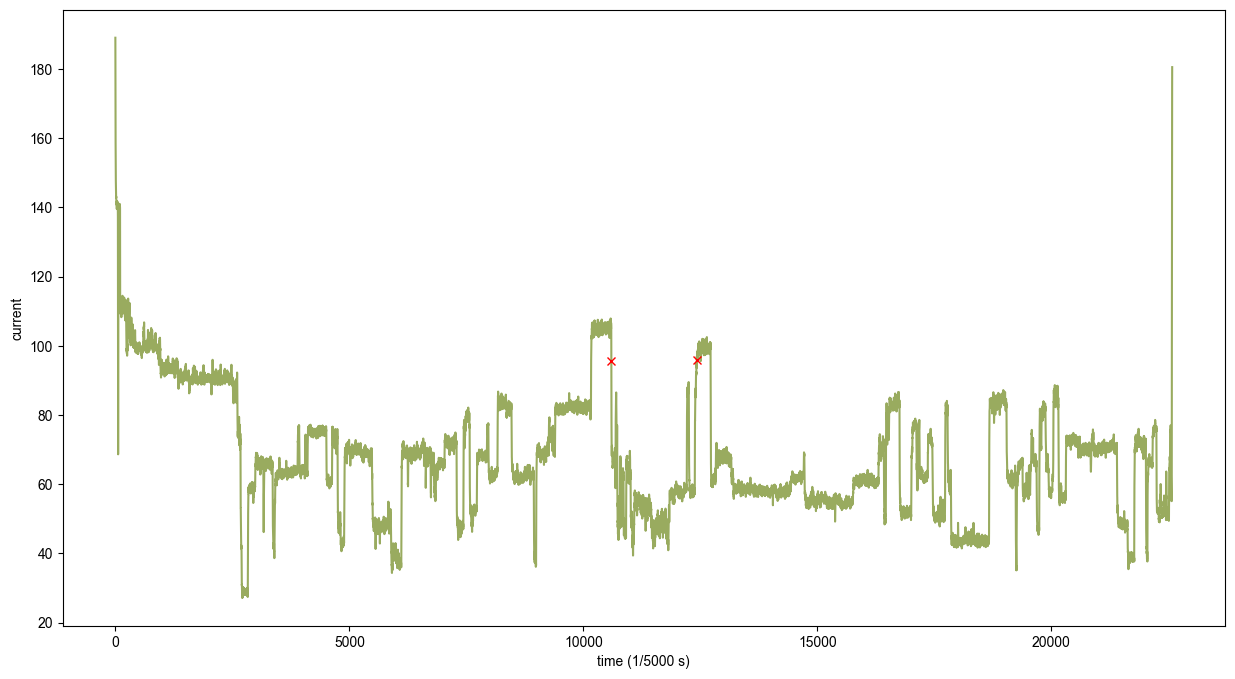

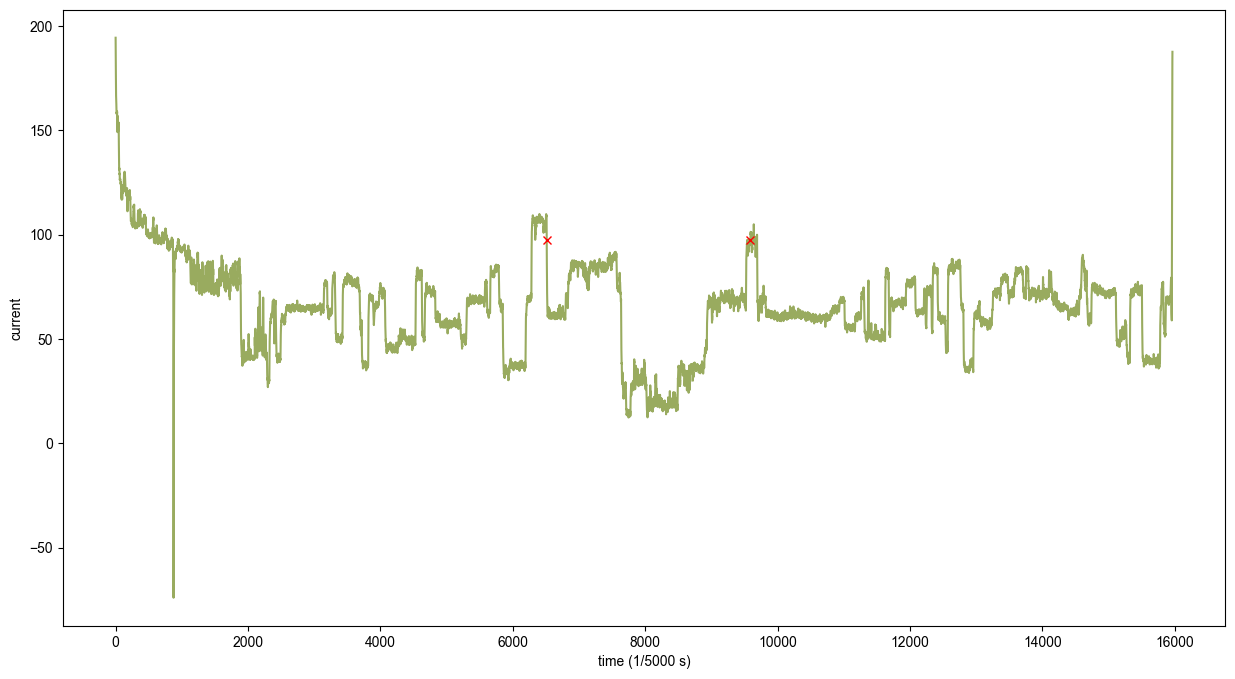

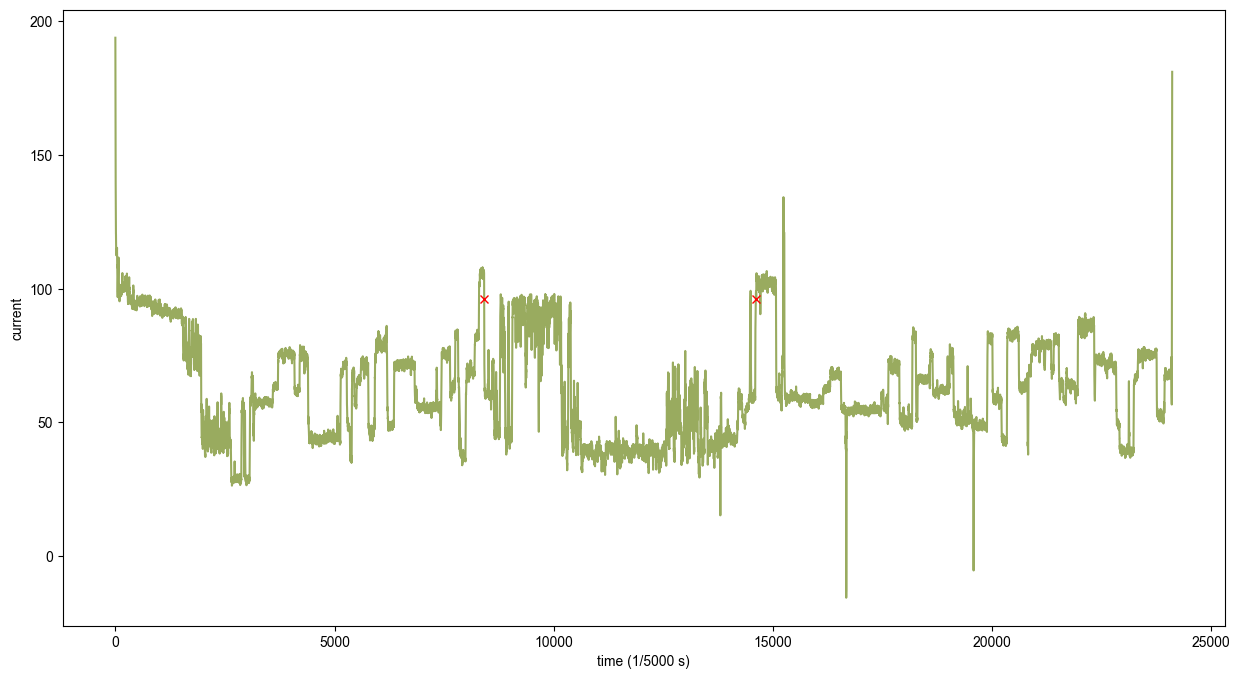

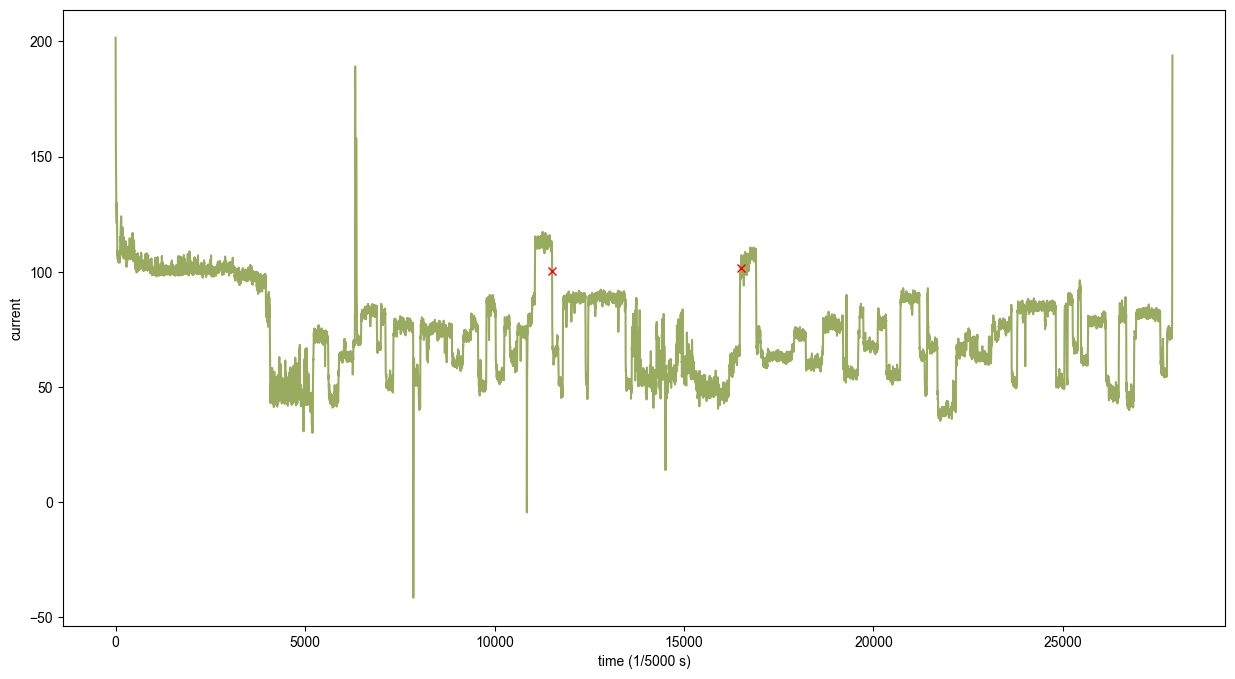

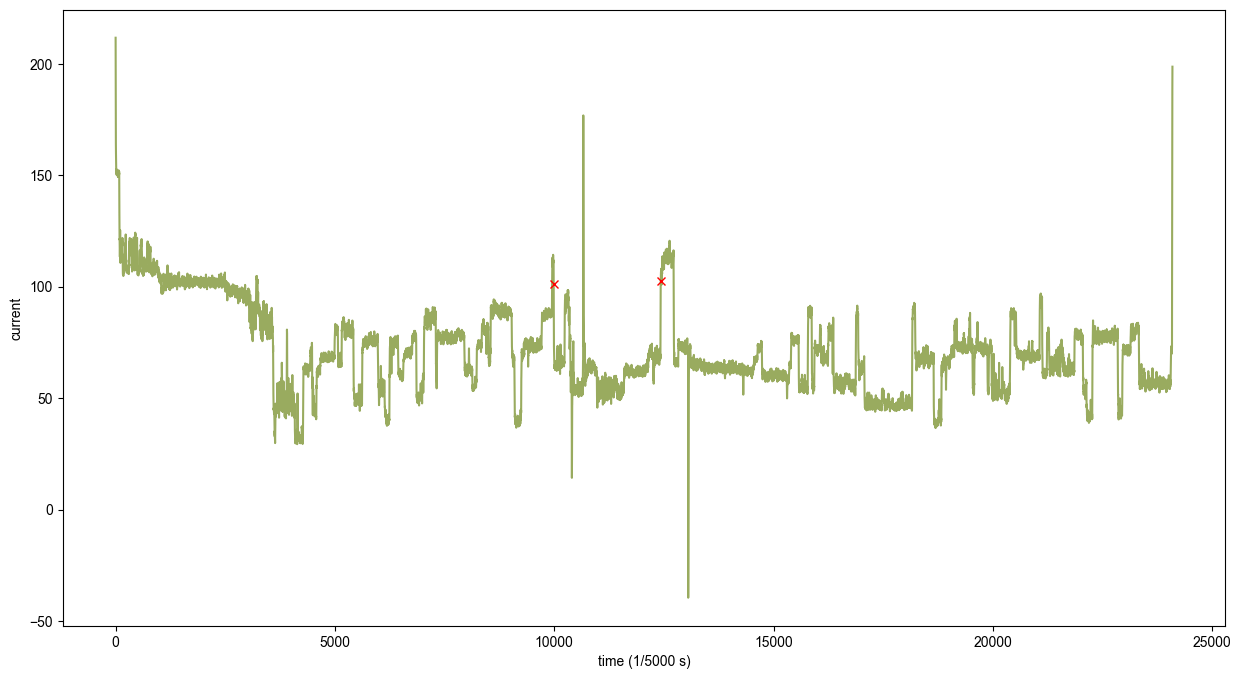

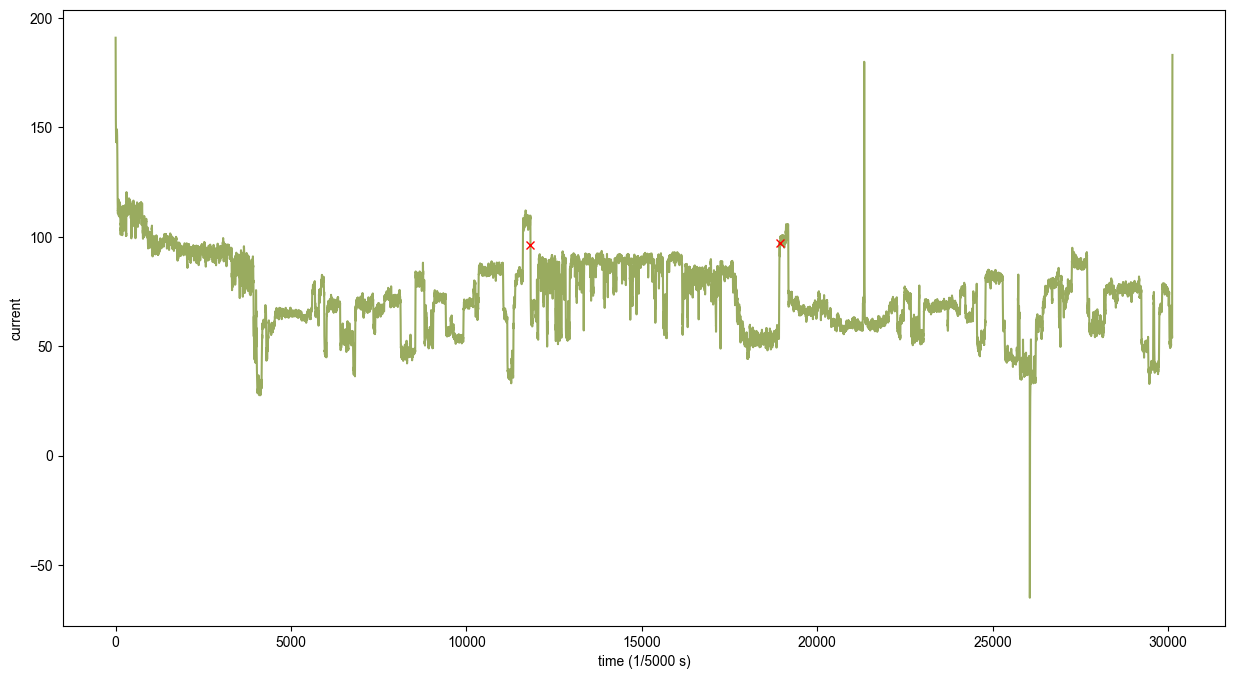

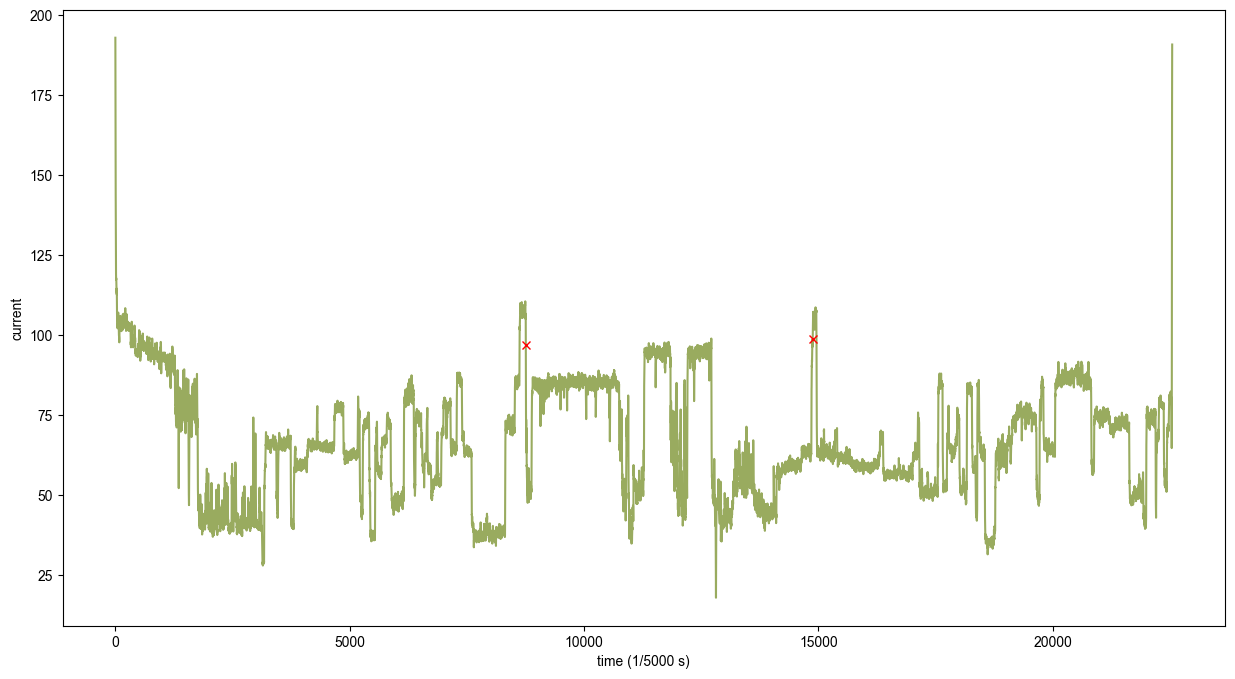

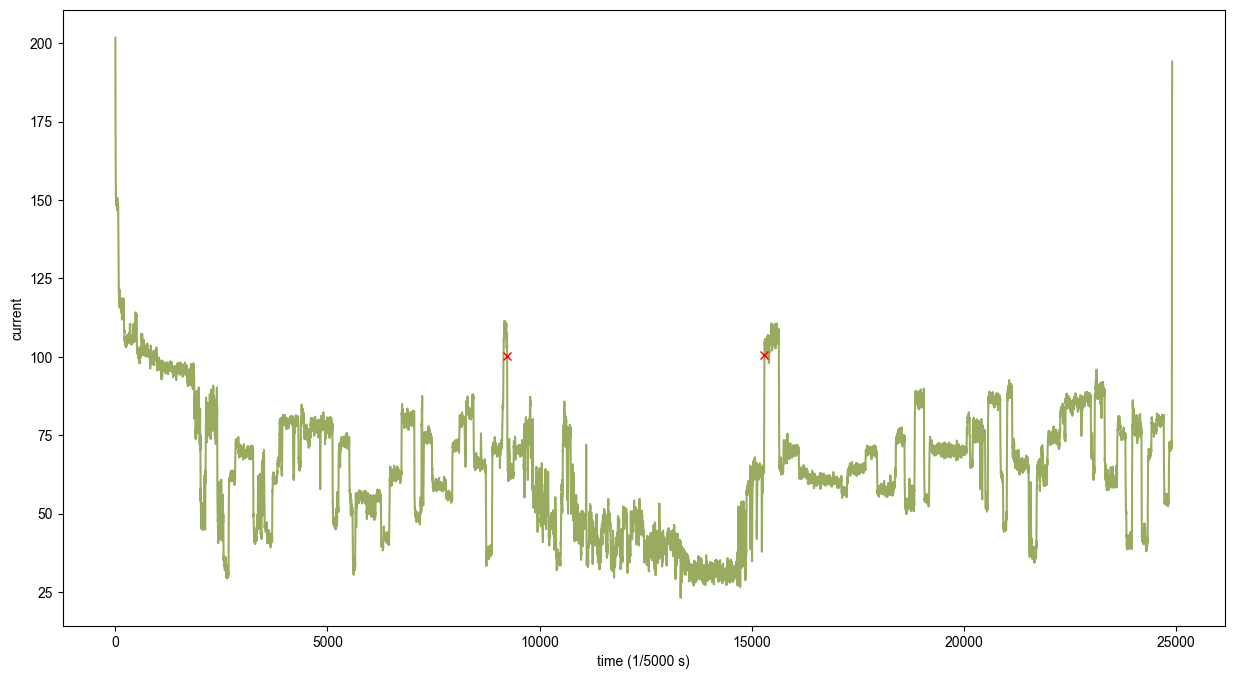

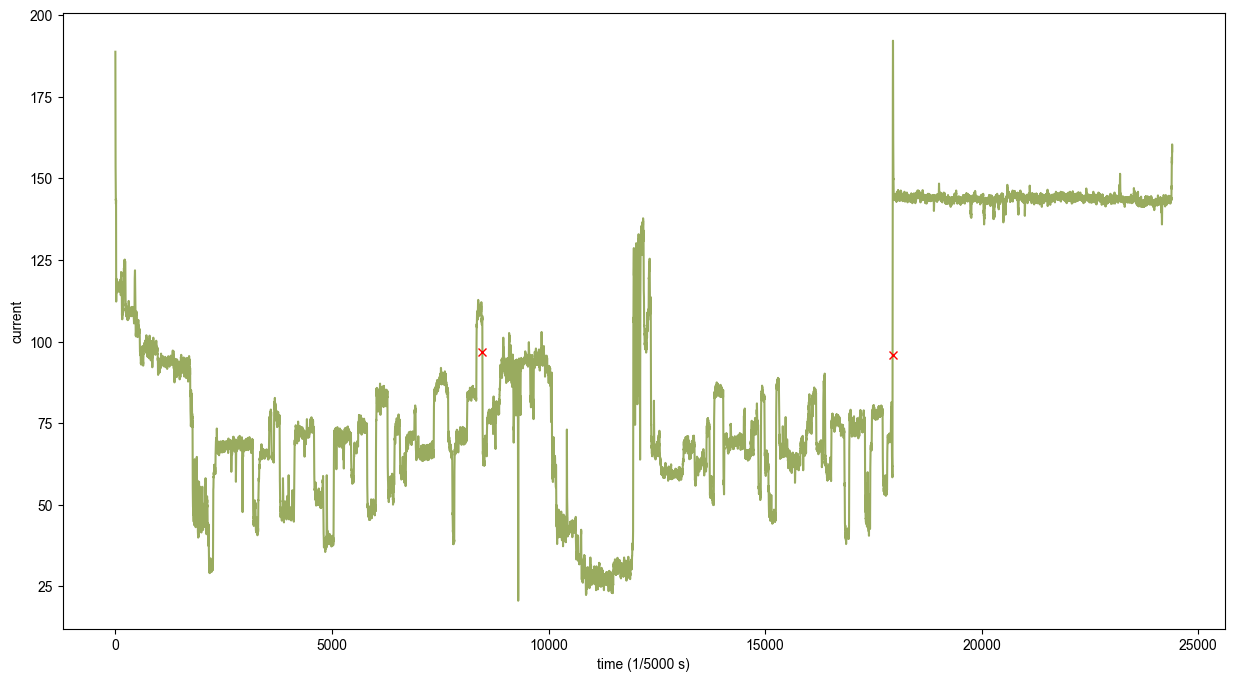

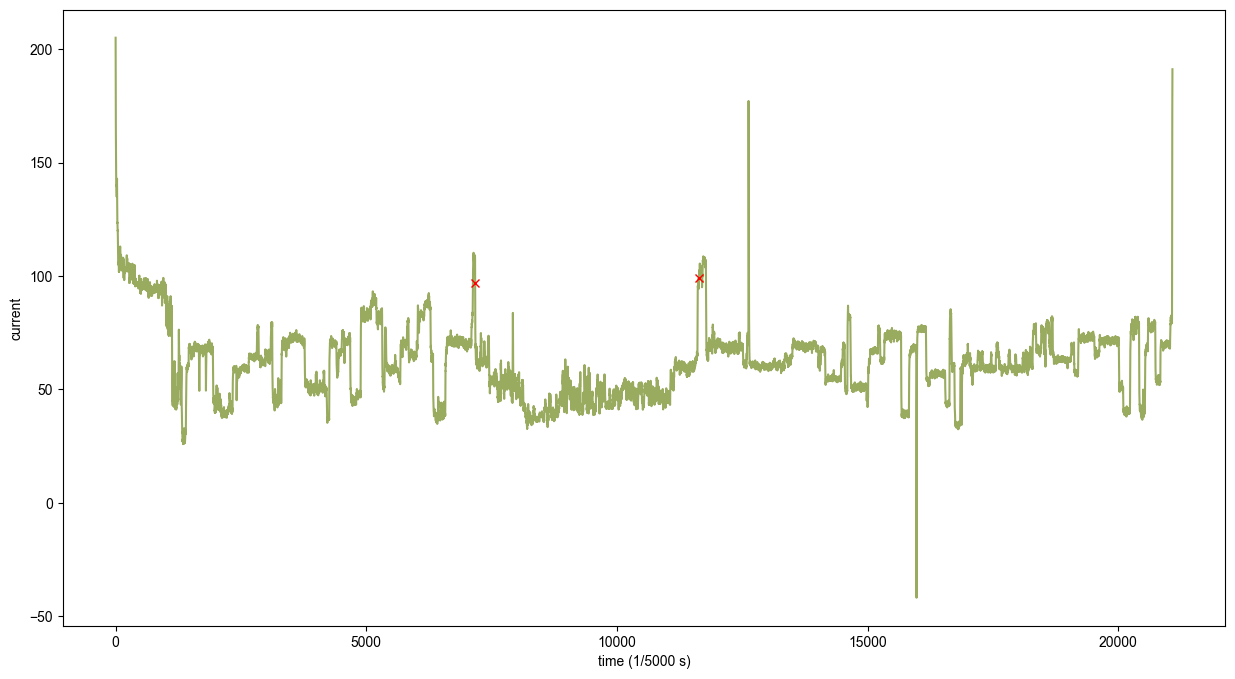

In [18]:
for i in range(10):
    nps.pl.draw_one_read_with_window(obj, pred_df[pred_df['pred']=='rejected'].index[i])

In [19]:
all_pred_df = []
for pep in all_peps:
    print(f'===={pep}====')
    obj = nps.io.read_pickle(f"../../../00.data/GSXGS/{pep}_valid20.pkl")
    test_objs = [obj]
    test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=['clean'], y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
    test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)
    pred_df = clf.predict(test_dl, name='cls_clean_and_rejected', y_to_label_dict=y_to_label_dict)
    all_pred_df.append(pred_df)
all_pred_df = pd.concat(all_pred_df)

====1K====
 test_acc: 0.6727
====1R====
 test_acc: 0.6829
====1D====
 test_acc: 0.6818
====1E====
 test_acc: 0.6831
====1F====
 test_acc: 0.6585
====1W====
 test_acc: 0.6390
====1Y====
 test_acc: 0.6308
====1I====
 test_acc: 0.6636
====1L====
 test_acc: 0.6754
====1M====
 test_acc: 0.6514
====1V====
 test_acc: 0.6710
====1H====
 test_acc: 0.6586
====1Q====
 test_acc: 0.6584
====1A====
 test_acc: 0.6563
====1G====
 test_acc: 0.6584
====1S====
 test_acc: 0.6596
====1C====
 test_acc: 0.5235
====1P====
 test_acc: 0.6722
====1T====
 test_acc: 0.6614
====1N====
 test_acc: 0.6828


In [20]:
all_pred_df.to_csv('../../../04.tables/classification_for_real_data/GSXGS/valid20_clean_or_rejected.csv')

In [21]:
all_pred_df = pd.read_csv('../../../04.tables/classification_for_real_data/GSXGS/valid20_clean_or_rejected.csv', index_col=0)
all_pred_df['pep'] = [re.search(r'(\S+?)_', i).group(1) for i in all_pred_df.index]
all_pred_stat_df = all_pred_df.groupby(['pep', 'pred']).size().reset_index(name='count')
all_pred_stat_df = all_pred_stat_df.pivot_table(index='pep', columns='pred', values='count')
all_pred_stat_df['clean_ratio'] = all_pred_stat_df['clean'] / (all_pred_stat_df['rejected'] + all_pred_stat_df['clean'])
all_pred_stat_df.to_csv('../../../04.tables/classification_for_real_data/GSXGS/valid20_clean_or_rejected_stat.csv')
all_pred_stat_df

pred,clean,rejected,clean_ratio
pep,,,
1A,7353.0,3850.0,0.656342
1C,2756.0,2509.0,0.523457
1D,11759.0,5488.0,0.681800
1E,8602.0,3990.0,0.683132
1F,4952.0,2568.0,0.658511
1G,9283.0,4816.0,0.658415
1H,3812.0,1976.0,0.658604
1I,21522.0,10911.0,0.663583
1K,20038.0,9748.0,0.672732
